# Calibration of the CIR++ model

We use differential evolution, found in the `scipy.optimize` package to calibrate our model to swaptions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.optimize import Bounds, NonlinearConstraint
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from FFTOptionPricing.CIR_plus_plus import calibrate_Svensson, CIR_plus_plus
from FFTOptionPricing.run_differential_evol import run_differential_evolution_with_polish

In [3]:
filepaths_FixedIncome = {
    'OIS': '/Users/goshabor/NTNU/9.Semester/TMA4500 – Fordypningsprosjekt/Data/OIS_DATA.xlsx',
    'SWPT': '/Users/goshabor/NTNU/9.Semester/TMA4500 – Fordypningsprosjekt/Data/swaption_data.xlsx'
}

In [4]:
#variables
OIS_DATA = pd.read_excel(filepaths_FixedIncome['OIS'])
SWPT_DATA = pd.read_excel(filepaths_FixedIncome['SWPT'])

VAL_DATE = OIS_DATA['VAL_DATE'].unique()[0]
START_DATE = OIS_DATA['START_DATE'].unique()[0]

Svensson_init_params = np.array([1.128326/100, 0.774661/100, -2.296025/100, 7.721684/100, 1/3.977482, 1/11.767271]) #data from ECB
Theta_r = np.array([0.1, 0.1, 0.1, 0.1]) #bogus Theta_r, needed to make an instance of CIR_plus_plus

IDX_TENOR = '3M'
fixed_leg_dt = 1

## 1.1 Calibration of the Svensson curve

In [5]:
Svensson = calibrate_Svensson(START_DATE=START_DATE, OIS_DATA=OIS_DATA, Svensson_init_params=Svensson_init_params)

df = Svensson.df
Svensson_params = Svensson.Svensson_params

print(f'Optimal Svensson parameters: {Svensson_params*100}')
print(f'Calibration error: {Svensson.result.fun}')

Optimal Svensson parameters: [ 0.98635546  0.93036623 -0.34151371  5.72489906 53.35349837  7.26479511]
Calibration error: 2.695516034596758e-07


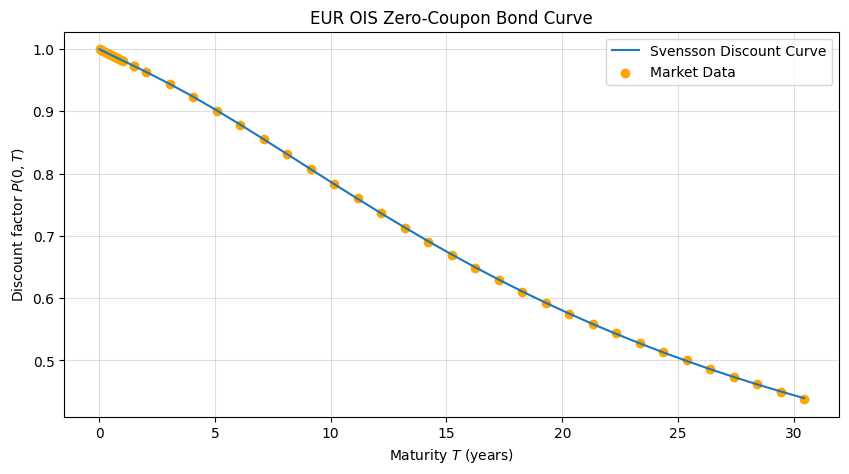

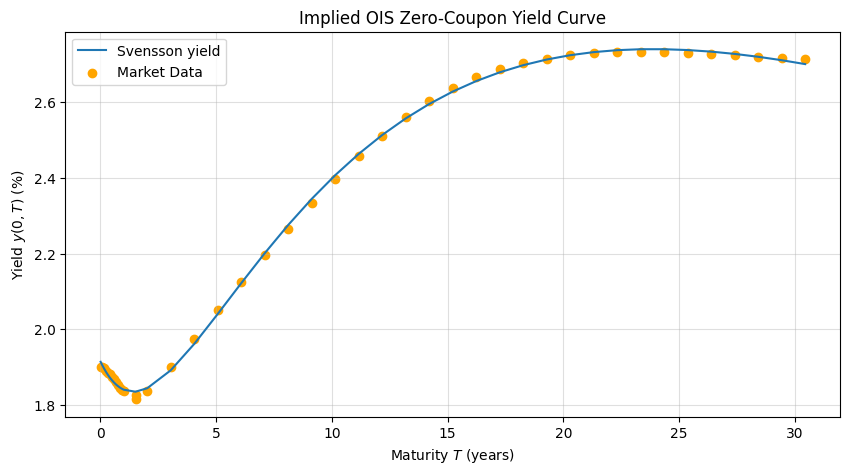

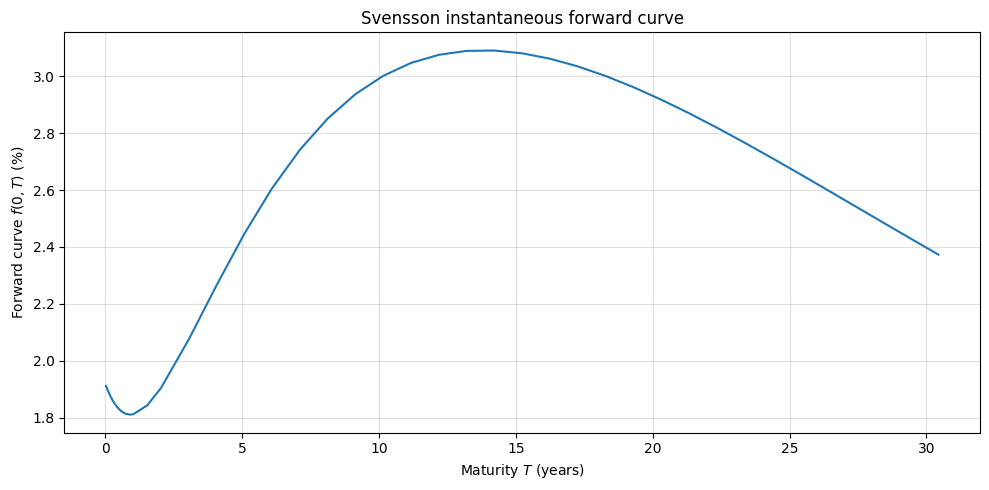

In [12]:
#visualisation
forward_curve = Svensson.Svensson_forward_curve(df['time_to_maturity'], Svensson_params)
yield_curve = Svensson.Svensson_yield_curve(df['time_to_maturity'], Svensson_params)

#discount factors
plt.figure(figsize=(10,5))
plt.plot(df['time_to_maturity'], np.exp(-df['time_to_maturity']*yield_curve), label='Svensson Discount Curve')
plt.scatter(df['time_to_maturity'], df['ZCB'], marker='o', color='orange', label='Market Data')
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('Discount factor $P(0,T)$')
plt.title('EUR OIS Zero-Coupon Bond Curve')
plt.legend()
plt.grid(True, alpha=0.4)

#ZCB yields
plt.figure(figsize=(10,5))
plt.plot(df['time_to_maturity'], 100*yield_curve, label='Svensson yield')
plt.scatter(df['time_to_maturity'], 100*df['yield'], marker='o', color='orange', label='Market Data')
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('Yield $y(0,T)$ (%)')
plt.title('Implied OIS Zero-Coupon Yield Curve')
plt.legend()
plt.grid(True, alpha=0.4)

#forward curve
plt.figure(figsize=(10,5))
plt.plot(df['time_to_maturity'], 100*forward_curve)
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('Forward curve $f(0,T)$ (%)')
plt.title('Svensson instantaneous forward curve')
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

## 1.2 Calibration of the CIR++ model

In [7]:
#bounds and constraints
lambda_swaptions = 1e8

lower_bound = np.array([1e-3, 1e-3, 1e-3, 1e-3])
upper_bound = np.array([0.5, 0.5, 0.05, 0.1]) #x0, kappa, theta, sigma
bounds = Bounds(lower_bound, upper_bound)

constraint = NonlinearConstraint(lambda th: th[3]**2 - 2*th[1]*th[2], -np.inf, 0.0)

#instance of CIR++ class
CIR = CIR_plus_plus(swaptions_df=SWPT_DATA, OIS_df=OIS_DATA, START_DATE=START_DATE, VAL_DATE=VAL_DATE, Svensson_init_params=Svensson_init_params, Theta_r=Theta_r, lambda_swaptions=lambda_swaptions, IDX_TENOR=IDX_TENOR, fixed_leg_dt=fixed_leg_dt)
swaptions = CIR.build_swaptions_from_df()

In [8]:
print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')

Lower bound: [0.001 0.001 0.001 0.001]
Upper bound: [0.5  0.5  0.05 0.1 ]


In [ ]:
differential_evolution_strat = 'randtobest1exp'

result_CIR = run_differential_evolution_with_polish(
    class_=CIR,
    args=(swaptions,),
    constraint=constraint,
    bounds=bounds,
    strategy=differential_evolution_strat, 
    x0=[0.10070984, 0.01024475, 0.03245518, 0.02578739] #from previous run
)
r0 = CIR.short_rate0(Theta_r=result_CIR.x, Svensson_params=CIR.Svensson_params)

In [ ]:
print(f'Theta_r: {result_CIR.x}')
print(f'r0: {r0}')

## 1.3 Model evaluation

### 1.3.1 Euler-Maruyama Simulation

In [9]:
#simulating using Euler-Maruyama
def sim_CIR_short_rates_EM(Theta_r, time_grid, n_sim, seed):
    rng = np.random.default_rng(seed)

    x0, kappa_r, theta_r, sigma_r = Theta_r
    n_steps = len(time_grid)
    dt = time_grid[1] - time_grid[0]

    x = np.zeros((n_sim, n_steps))
    x[:,0] = x0

    dW = rng.normal(0.0, np.sqrt(dt), size=(n_sim, n_steps-1))
    
    for i in range(1, n_steps):
        x_prev = np.maximum(x[:,i-1],0)
        x[:,i] = x_prev + (kappa_r*(theta_r-x_prev) - sigma_r**2*CIR.B(0, time_grid[i], Theta_r)*x_prev)*dt + sigma_r*np.sqrt(x_prev)*dW[:,i-1] #under Q^T
    return x

def sim_CIR_plus_plus(Theta_r, T, n_grid, n_sim=10000, seed=42):
    time_grid = np.linspace(0.0, T, n_grid)

    x_paths = sim_CIR_short_rates_EM(Theta_r, time_grid, n_sim, seed)
    psi = np.asarray(CIR.psi_CIR(time_grid, Theta_r), dtype=float)
    
    r_paths = x_paths + psi[None, :]
    return time_grid, r_paths

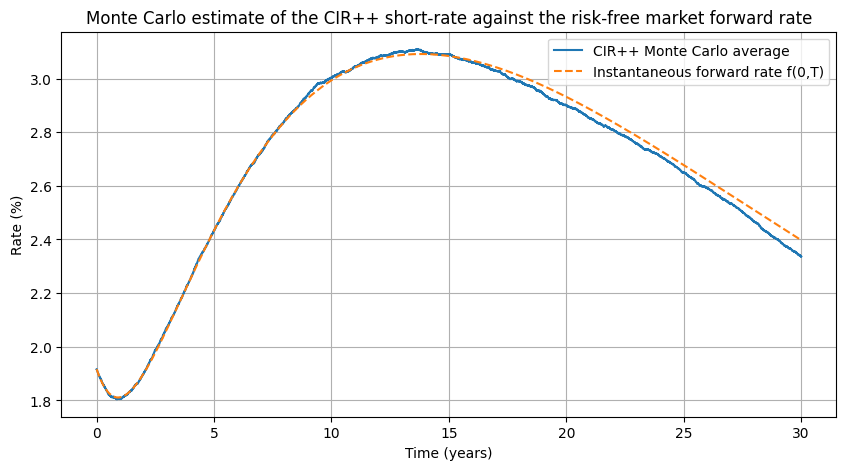

In [11]:
factor = 3
T = 30
n_grid = int(factor*(T*365 + 1))
n_sim = 10000

#Theta_r = result_CIR.x
Theta_r = [0.10070984, 0.01024475, 0.03245518, 0.02578739]
r0 = CIR.short_rate0(Theta_r=Theta_r, Svensson_params=CIR.Svensson_params)

time_grid, r_EM = sim_CIR_plus_plus(Theta_r=Theta_r, T=T, n_grid=n_grid, n_sim=n_sim, seed=42)

plt.figure(figsize=(10,5))
plt.plot(time_grid, 100*r_EM.mean(axis=0), label='CIR++ Monte Carlo average')
plt.plot(time_grid, 100*Svensson.Svensson_forward_curve(t=time_grid, Svensson_params=Svensson_params), label='Instantaneous forward rate f(0,T)', linestyle='--')
plt.xlabel('Time (years)')
plt.ylabel('Rate (%)')
plt.title(f'Monte Carlo estimate of the CIR++ short-rate against the risk-free market forward rate')
plt.legend()
plt.grid()
plt.show()

### 1.3.2 Swaptions evaluation

In [20]:
def model_prices_Fixed_Income(swaptions_data, Theta_r, r0, VAL_DATE, fixed_leg_dt=1):
    swaptions_df = swaptions_data.copy()

    swaptions_df['model_premium_pct'] = np.nan
    swaptions_df['premium_error_pct'] = np.nan
    
    for i, row in swaptions_df.iterrows():
        T = (pd.to_datetime(row['expiry']) - pd.to_datetime(VAL_DATE)).days/365
        tenor_years = CIR.tenor_to_years(row['tenor'])
        T_arr = CIR.make_schedule(T, T+tenor_years, fixed_leg_dt)
        X = row['strike_pct']/100

        model_price = CIR.payer_swaption_price(0, T, T_arr, 1, X, Theta_r, r0)
        swaptions_df.at[i, 'model_premium_pct'] = model_price*100
        swaptions_df.at[i, 'premium_error_pct'] = abs(swaptions_df.at[i, 'model_premium_pct'] - row['premium_pct'])
    
    return swaptions_df

In [49]:
swaptions_df = model_prices_Fixed_Income(SWPT_DATA, Theta_r, r0, VAL_DATE)

MAE = mean_absolute_error(y_true=swaptions_df['model_premium_pct']/100, y_pred=swaptions_df['premium_pct']/100)
RMSE = np.sqrt(mean_squared_error(y_true=swaptions_df['model_premium_pct']/100, y_pred=swaptions_df['premium_pct']/100))
MAPE = mean_absolute_percentage_error(y_true=swaptions_df['model_premium_pct']/100, y_pred=swaptions_df['premium_pct']/100) * 100

print(f'MAE={round(MAE*100, 6)}%')
print(f'RMSE={round(RMSE*100, 6)}%')
print(f'MAPE={round(MAPE, 6)}%')

MAE=0.067888%
RMSE=0.091902%
MAPE=2.912893%


In [46]:
# store Theta_r
keys = ['VAL_DATE', 'r0', 'x0', 'kappa_r', 'theta_r', 'sigma_r', 'beta0', 'beta1', 'beta2', 'beta3', 'a1', 'a2']
Theta_r = np.asarray(Theta_r).ravel().tolist()
Svensson_params = np.asarray(Svensson_params).ravel().tolist()
short_rate_params_list = [VAL_DATE, r0] + Theta_r + Svensson_params

swaptions_df.to_excel('/Users/goshabor/NTNU/9.Semester/TMA4500 – Fordypningsprosjekt/Code/CIRPlusPlusResults/swaptions_df.xlsx', index=False)
swaptions_df.to_csv('/Users/goshabor/NTNU/9.Semester/TMA4500 – Fordypningsprosjekt/Code/CIRPlusPlusResults/swaptions_df.csv', index=False)
pd.DataFrame(dict(zip(keys, short_rate_params_list)), index=[0]).to_csv('/Users/goshabor/NTNU/9.Semester/TMA4500 – Fordypningsprosjekt/Code/CIRPlusPlusResults/short_rate_params.csv', index=False)